In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
faostat_df = pd.read_csv("FAOSTAT_data_en_11-19-2025.csv")   
crop_df    = pd.read_csv("Crop_recommendation.csv")          

print("FAOSTAT head:")
print(faostat_df.head())

print("\nCrop dataset head:")
print(crop_df.head())


FAOSTAT head:
  Domain Code                        Domain  Area Code (M49)   Area  \
0         QCL  Crops and livestock products              356  India   
1         QCL  Crops and livestock products              356  India   
2         QCL  Crops and livestock products              356  India   
3         QCL  Crops and livestock products              356  India   
4         QCL  Crops and livestock products              356  India   

   Element Code         Element  Item Code (CPC)  \
0          5312  Area harvested           1654.0   
1          5412           Yield           1654.0   
2          5510      Production           1654.0   
3          5312  Area harvested           1654.0   
4          5412           Yield           1654.0   

                                                Item  Year Code  Year   Unit  \
0  Anise, badian, coriander, cumin, caraway, fenn...       2000  2000     ha   
1  Anise, badian, coriander, cumin, caraway, fenn...       2000  2000  kg/ha   
2  Ani

In [3]:
faostat_india = faostat_df[faostat_df["Area"] == "India"].copy()

print("FAOSTAT India head:")
print(faostat_india.head())
print("FAOSTAT India shape:", faostat_india.shape)


FAOSTAT India head:
  Domain Code                        Domain  Area Code (M49)   Area  \
0         QCL  Crops and livestock products              356  India   
1         QCL  Crops and livestock products              356  India   
2         QCL  Crops and livestock products              356  India   
3         QCL  Crops and livestock products              356  India   
4         QCL  Crops and livestock products              356  India   

   Element Code         Element  Item Code (CPC)  \
0          5312  Area harvested           1654.0   
1          5412           Yield           1654.0   
2          5510      Production           1654.0   
3          5312  Area harvested           1654.0   
4          5412           Yield           1654.0   

                                                Item  Year Code  Year   Unit  \
0  Anise, badian, coriander, cumin, caraway, fenn...       2000  2000     ha   
1  Anise, badian, coriander, cumin, caraway, fenn...       2000  2000  kg/ha   


In [4]:
print("Before explosion shape:", faostat_india.shape)
print(faostat_india[["Item"]].head())

# split on comma and strip spaces
faostat_india["crop"] = (
    faostat_india["Item"]
      .str.split(",")
      .apply(lambda lst: [x.strip() for x in lst])
)

faostat_exploded = faostat_india.explode("crop").reset_index(drop=True)

print("\nAfter explosion shape:", faostat_exploded.shape)
print(faostat_exploded[["Item","crop"]].head())


Before explosion shape: (5940, 15)
                                                Item
0  Anise, badian, coriander, cumin, caraway, fenn...
1  Anise, badian, coriander, cumin, caraway, fenn...
2  Anise, badian, coriander, cumin, caraway, fenn...
3  Anise, badian, coriander, cumin, caraway, fenn...
4  Anise, badian, coriander, cumin, caraway, fenn...

After explosion shape: (9160, 16)
                                                Item       crop
0  Anise, badian, coriander, cumin, caraway, fenn...      Anise
1  Anise, badian, coriander, cumin, caraway, fenn...     badian
2  Anise, badian, coriander, cumin, caraway, fenn...  coriander
3  Anise, badian, coriander, cumin, caraway, fenn...      cumin
4  Anise, badian, coriander, cumin, caraway, fenn...    caraway


In [5]:
faostat_exploded = faostat_exploded.rename(columns={"Item": "item"})



crop_df = crop_df.rename(columns={"label": "crop"})

print("Crop columns after rename:", crop_df.columns)
print("FAOSTAT columns after rename:", faostat_exploded.columns)


Crop columns after rename: Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'crop'], dtype='object')
FAOSTAT columns after rename: Index(['Domain Code', 'Domain', 'Area Code (M49)', 'Area', 'Element Code',
       'Element', 'Item Code (CPC)', 'item', 'Year Code', 'Year', 'Unit',
       'Value', 'Flag', 'Flag Description', 'Note', 'crop'],
      dtype='object')


In [6]:
label_to_fao = {
    "apple":      "Apples",
    "banana":     "Bananas",
    "chickpea":   "Chick peas",
    "coconut":    "Coconuts",
    "coffee":     "Coffee",
    "cotton":     "Seed cotton",
    "grapes":     "Grapes",
    "jute":       "Jute",
    "lentil":     "Lentils",
    "maize":      "Maize (corn)",
    "mango":      "Mangoes",
    "mothbeans":  "Beans",
    "muskmelon":  "Cantaloupes and other melons",
    "orange":     "Oranges",
    "papaya":     "Papayas",
    "pigeonpeas": "Pigeon peas",
    "rice":       "Rice",
    "watermelon": "Watermelons",
}


In [7]:
crop_df["FAO_name"] = crop_df["crop"].map(label_to_fao)

faostat_exploded["FAO_name"] = faostat_exploded["crop"]


crop_mapped = crop_df[~crop_df["FAO_name"].isna()].copy()

merged = faostat_exploded.merge(
    crop_mapped,
    on="FAO_name",
    how="inner",
    suffixes=("_fao", "_ml")
)

print("Merged shape:", merged.shape)
print("Unique ML crops after mapping:", merged["crop_ml"].nunique())
print(sorted(merged["crop_ml"].unique()))


Merged shape: (129600, 25)
Unique ML crops after mapping: 18
['apple', 'banana', 'chickpea', 'coconut', 'coffee', 'cotton', 'grapes', 'jute', 'lentil', 'maize', 'mango', 'mothbeans', 'muskmelon', 'orange', 'papaya', 'pigeonpeas', 'rice', 'watermelon']


In [8]:
merged["crop"] = merged["crop_ml"]


In [9]:
merged_prod = merged[merged["Element"] == "Production"].copy() 

In [10]:
cols_keep = ["Element","Value","N","P","K","temperature","humidity","ph","rainfall","crop"]
final_df = merged[cols_keep].copy()
final_df = final_df[final_df["Element"] == "Production"].copy()

In [11]:
numeric_cols = ["Value","N","P","K","temperature","humidity","ph","rainfall"]
for col in numeric_cols:
    Q1 = final_df[col].quantile(0.25)
    Q3 = final_df[col].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR
    final_df = final_df[(final_df[col] >= low) & (final_df[col] <= high)]

In [12]:
print("Unique crops:", sorted(final_df["crop"].unique()))
print("Number of unique crops:", final_df["crop"].nunique())
print(final_df["crop"].value_counts())

Unique crops: ['banana', 'chickpea', 'coconut', 'coffee', 'cotton', 'jute', 'lentil', 'maize', 'mango', 'mothbeans', 'muskmelon', 'orange', 'papaya', 'pigeonpeas', 'watermelon']
Number of unique crops: 15
crop
muskmelon     2400
coconut       2400
coffee        2400
jute          2400
lentil        2400
cotton        2400
watermelon    2400
mango         2136
maize         2100
chickpea      2088
pigeonpeas    1944
orange        1872
banana        1500
papaya        1488
mothbeans     1296
Name: count, dtype: int64


In [13]:
final_df

,Element,Value,N,P,K,temperature,humidity,ph,rainfall,crop
7400,Production,14137300.0,91,94,46,29.367924,76.249001,6.149934,92.828409,banana
7401,Production,14137300.0,105,95,50,27.333690,83.676752,5.849076,101.049479,banana
7402,Production,14137300.0,108,92,53,27.400536,82.962213,6.276800,104.937800,banana
7403,Production,14137300.0,86,76,54,29.315908,80.115857,5.926825,90.109781,banana
7404,Production,14137300.0,80,77,49,26.054330,79.396545,5.519088,113.229737,banana
...,...,...,...,...,...,...,...,...,...,...
129595,Production,3626000.0,97,12,47,25.287846,89.636679,6.765095,58.286977,watermelon
129596,Production,3626000.0,110,7,45,26.638386,84.695469,6.189214,48.324286,watermelon
129597,Production,3626000.0,96,18,50,25.331045,84.305338,6.904242,41.532187,watermelon
129598,Production,3626000.0,83,23,55,26.897502,83.892415,6.463271,43.971937,watermelon


In [14]:
print("Null counts:")
print(final_df.isna().sum())


Null counts:
Element        0
Value          0
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
crop           0
dtype: int64


In [15]:
print("Duplicate rows:", final_df.duplicated().sum())
final_df = final_df.drop_duplicates().reset_index(drop=True)
print("Shape after dropping duplicates:", final_df.shape)


Duplicate rows: 534
Shape after dropping duplicates: (30690, 10)


In [16]:
final_df.to_csv("Clean_FAOSTAT_Crop_18crops.csv", index=False)


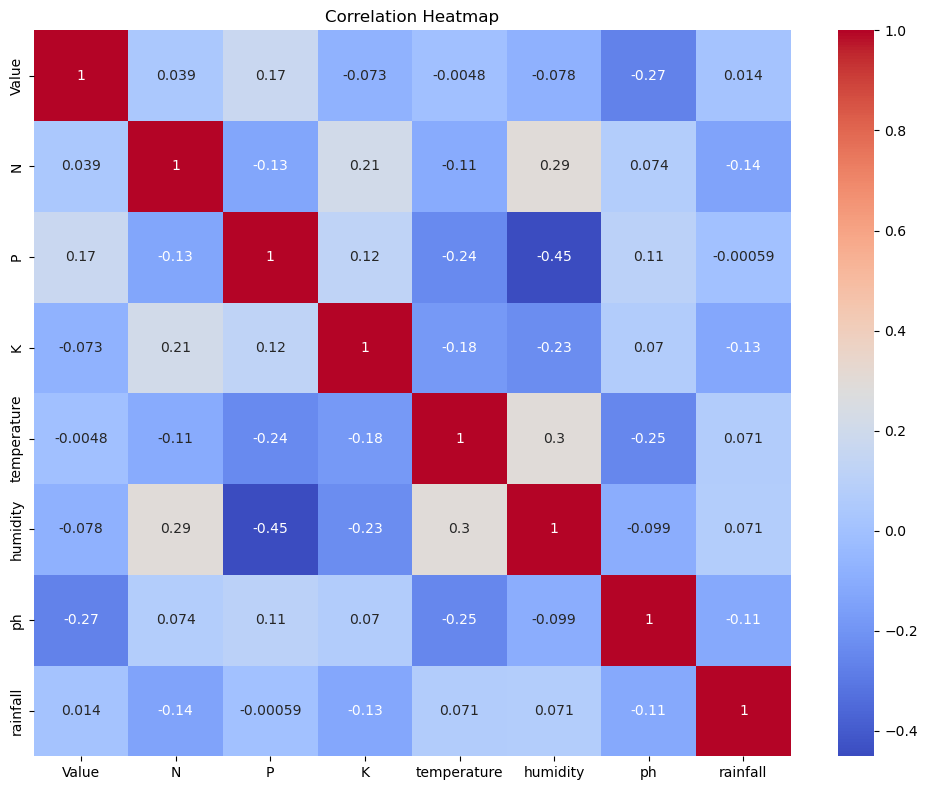

In [17]:
plt.figure(figsize=(10,8))
sns.heatmap(final_df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


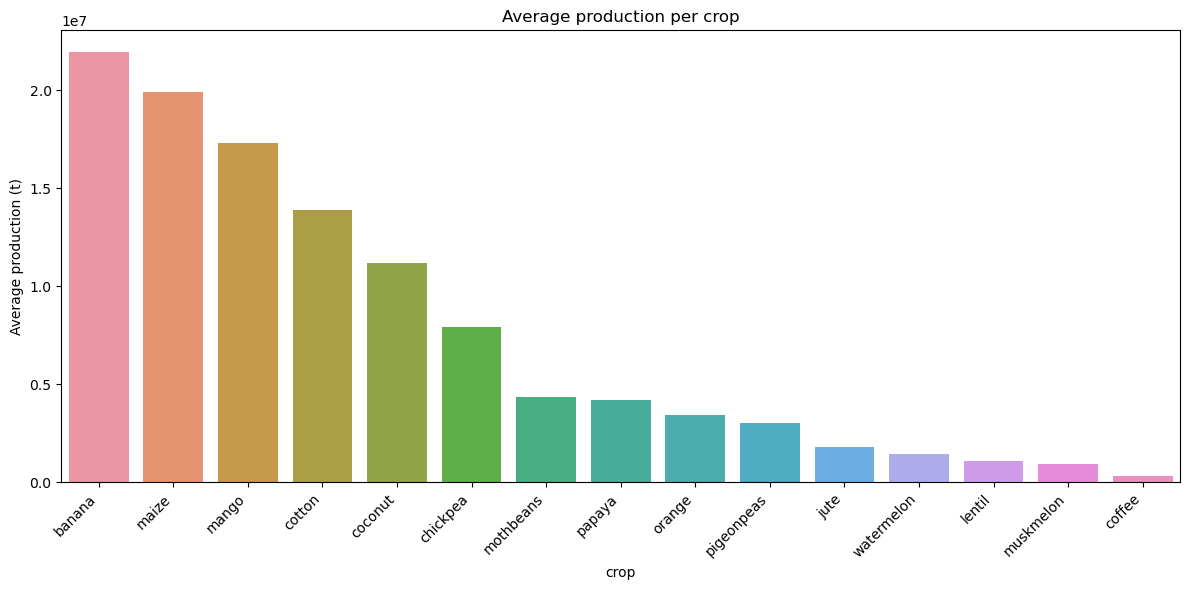

In [18]:
plt.figure(figsize=(12,6))
mean_prod = final_df.groupby("crop")["Value"].mean().sort_values(ascending=False)
sns.barplot(x=mean_prod.index, y=mean_prod.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Average production (t)")
plt.title("Average production per crop")
plt.tight_layout()
plt.show()


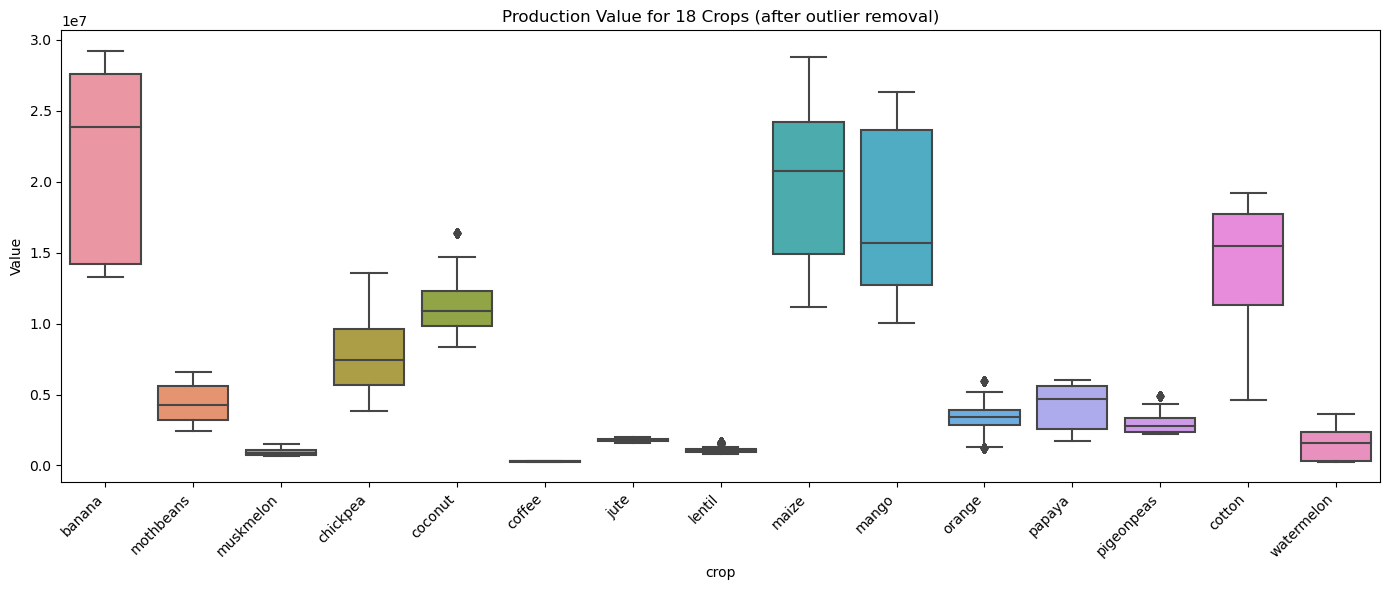

In [19]:
plt.figure(figsize=(14,6))
sns.boxplot(data=final_df, x="crop", y="Value")
plt.xticks(rotation=45, ha="right")
plt.title("Production Value for 18 Crops (after outlier removal)")
plt.tight_layout()
plt.show()


In [20]:
print(final_df["crop"].value_counts())

crop
coconut       2400
jute          2400
lentil        2400
cotton        2400
watermelon    2400
muskmelon     2300
coffee        2300
mango         2136
chickpea      2088
maize         2000
pigeonpeas    1944
orange        1638
banana        1500
papaya        1488
mothbeans     1296
Name: count, dtype: int64


In [21]:
print("Unique crops:", sorted(final_df["crop"].unique()))
print("Number of unique crops:", final_df["crop"].nunique())
print(final_df["crop"].value_counts())

Unique crops: ['banana', 'chickpea', 'coconut', 'coffee', 'cotton', 'jute', 'lentil', 'maize', 'mango', 'mothbeans', 'muskmelon', 'orange', 'papaya', 'pigeonpeas', 'watermelon']
Number of unique crops: 15
crop
coconut       2400
jute          2400
lentil        2400
cotton        2400
watermelon    2400
muskmelon     2300
coffee        2300
mango         2136
chickpea      2088
maize         2000
pigeonpeas    1944
orange        1638
banana        1500
papaya        1488
mothbeans     1296
Name: count, dtype: int64


In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [23]:
# Prepare X, y 

X = final_df.drop(columns=["Value", "Element"], errors="ignore")
y = final_df["Value"]


X = pd.get_dummies(X, columns=["crop"], drop_first=True)

In [24]:
#train, test splitting 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=32
)

In [25]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=200, random_state=42
    ),
    "XGBoost": XGBRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    ),
}

In [26]:
print("Training and Evaluating Models...\n")

for name, model in models.items():
    model.fit(X_train, y_train)

    # train and test predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # metrics
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, y_train_pred)

    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_test_pred)

    print(f"=== {name} ===")
    print(f"Train MSE : {mse_train:.2f}")
    print(f"Train MAE : {mae_train:.2f}")
    print(f"Train RMSE: {rmse_train:.2f}")
    print(f"Train R²  : {r2_train:.4f}")
    print(f"Test  MSE : {mse_test:.2f}")
    print(f"Test  MAE : {mae_test:.2f}")
    print(f"Test  RMSE: {rmse_test:.2f}")
    print(f"Test  R²  : {r2_test:.4f}\n")


Training and Evaluating Models...

=== Linear Regression ===
Train MSE : 8894845495109.61
Train MAE : 1844120.20
Train RMSE: 2982422.76
Train R²  : 0.8495
Test  MSE : 8983969692931.05
Test  MAE : 1859409.83
Test  RMSE: 2997327.09
Test  R²  : 0.8470

=== Random Forest ===
Train MSE : 8750322348268.23
Train MAE : 1822058.61
Train RMSE: 2958094.38
Train R²  : 0.8519
Test  MSE : 10073742363061.97
Test  MAE : 1956426.51
Test  RMSE: 3173915.94
Test  R²  : 0.8285

=== XGBoost ===
Train MSE : 8788522629091.87
Train MAE : 1836934.17
Train RMSE: 2964544.25
Train R²  : 0.8513
Test  MSE : 9764828945216.43
Test  MAE : 1931543.25
Test  RMSE: 3124872.63
Test  R²  : 0.8337



In [27]:
from sklearn.model_selection import GridSearchCV

# base XGB model
xg_base = XGBRegressor(
    random_state=42,
    n_jobs=-1,
)


In [28]:
param_grid = {
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [200, 300],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
}

grid = GridSearchCV(
    estimator=xg_base,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
)

In [29]:
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Best CV score (neg RMSE):", grid.best_score_)


Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Best CV score (neg RMSE): -3083706.152177511


In [30]:
y_grid_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_grid_pred)
mae = mean_absolute_error(y_test, y_grid_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_grid_pred)

print("\nHyper‑tuned XGBoost metrics on TEST:")
print("Hyper MSE :", mse)
print("Hyper MAE :", mae)
print("Hyper RMSE:", rmse)
print("Hyper R²  :", r2)


Hyper‑tuned XGBoost metrics on TEST:
Hyper MSE : 9477320721791.559
Hyper MAE : 1950594.178354824
Hyper RMSE: 3078525.7383675645
Hyper R²  : 0.83861255453188


In [31]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ---------- encode crop as integer (for this alternative pipeline) ----------
df_encoded = final_df.copy()
encoder = LabelEncoder()
df_encoded["Crops"] = encoder.fit_transform(df_encoded["crop"])
df_encoded = df_encoded.drop(columns=["crop"])

In [32]:
# scale features
X2 = df_encoded.drop(columns=["Value", "Element"], errors="ignore")
y2 = df_encoded["Value"]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X2_scaled = scaler.fit_transform(X2)

In [33]:
# split (use same random_state as teammate)
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X2_scaled, y2, test_size=0.25, random_state=32
)


In [34]:
# train tuned XGBoost from grid search on this scaled data
xg_model = XGBRegressor(
    **grid.best_params_,
    random_state=42,
    n_jobs=-1,
)
xg_model.fit(X_train2, y_train2)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=-1, num_parallel_tree=None, ...)

In [35]:
# metrics for this pipeline
y_train_pred2 = xg_model.predict(X_train2)
y_test_pred2 = xg_model.predict(X_test2)

print("Scaled‑XGB Train R²:", r2_score(y_train2, y_train_pred2))
print("Scaled‑XGB Test  R²:", r2_score(y_test2, y_test_pred2))

Scaled‑XGB Train R²: 0.8490111068786909
Scaled‑XGB Test  R²: 0.8407206615530229


In [36]:
#sample data
sample_data = {
    "N": 110,
    "P": 50,
    "K": 48,
    "temperature": 27.5,
    "humidity": 80,
    "ph": 6.2,
    "rainfall": 190,
    "Year": 2018,
    "Crops": "banana",
}

# encode crop to integer ID
sample_data["Crops"] = encoder.transform([sample_data["Crops"]])[0]

# order columns exactly like X2
sample_df = pd.DataFrame([sample_data])[X2.columns]

# scale using SAME scaler (this avoids the warning)
sample_scaled = scaler.transform(sample_df)

# predict
pred_value = int(xg_model.predict(sample_scaled)[0])
print("Predicted Value for sample:", pred_value)


Predicted Value for sample: 19912598


In [51]:
import joblib

joblib.dump(clf, "crop_model_xgb.pkl")
joblib.dump(le,  "label_encoder.pkl")
print("Saved crop_model_xgb.pkl and label_encoder.pkl")


Saved crop_model_xgb.pkl and label_encoder.pkl


In [52]:
import joblib
import pandas as pd

model = joblib.load("crop_model_xgb.pkl")
le    = joblib.load("label_encoder.pkl")

def predict_all_crops(user_input: dict) -> pd.DataFrame:
    user_df = pd.DataFrame([user_input])
    probs = model.predict_proba(user_df)[0]      # one prob per crop
    crops = le.classes_

    prob_df = pd.DataFrame({
        "Crop": crops,
        "Probability": probs
    }).sort_values("Probability", ascending=False).reset_index(drop=True)
    return prob_df


In [49]:
user_input = {"N":90,"P":40,"K":40,"temperature":25,"humidity":80,"ph":6.5,"rainfall":120}
prob_df = predict_all_crops(user_input)
prob_df.head()

,Crop,Probability
0,jute,0.222657
1,coffee,0.166757
2,chickpea,0.067296
3,muskmelon,0.063486
4,banana,0.060210


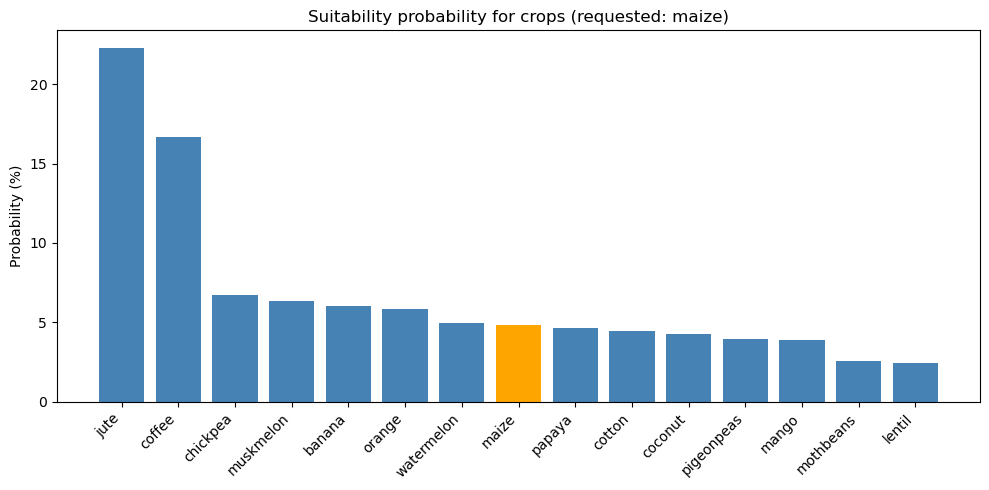

In [53]:
import matplotlib.pyplot as plt

def plot_probabilities(prob_df, top_k=None, requested_crop=None):
    # optionally keep only top_k crops
    if top_k is not None:
        df = prob_df.head(top_k)
    else:
        df = prob_df

    crops = df["Crop"].tolist()
    probs_percent = (df["Probability"] * 100).tolist()

    # highlight requested crop if given
    colors = [
        "orange" if (requested_crop is not None and c.lower() == requested_crop.lower())
        else "steelblue"
        for c in crops
    ]

    plt.figure(figsize=(10, 5))
    plt.bar(crops, probs_percent, color=colors)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Probability (%)")
    title = "Suitability probability for crops"
    if requested_crop:
        title += f" (requested: {requested_crop})"
    plt.title(title)
    plt.tight_layout()
    plt.show()

# example:
plot_probabilities(prob_df, top_k=None, requested_crop="maize")


In [55]:
user_input = {"N":30,"P":60,"K":70,"temperature":15,"humidity":70,"ph":7.5,"rainfall":100}
prob_df = predict_all_crops(user_input)
prob_df.head()

,Crop,Probability
0,papaya,0.218596
1,pigeonpeas,0.163085
2,watermelon,0.073743
3,banana,0.059770
4,chickpea,0.056402


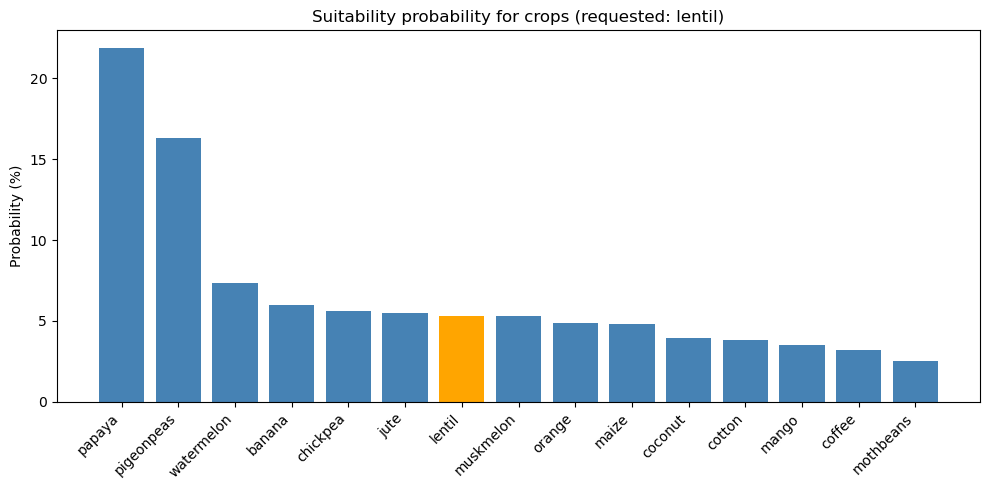

In [56]:
prob_df = predict_all_crops(user_input)   # your new input
plot_probabilities(prob_df, top_k=None, requested_crop="lentil")
